## 프로젝트: 자율주행 보조 시스템 만들기

#### KITTI 데이터셋 준비

In [ ]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

Matplotlib is building the font cache; this may take a moment.


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

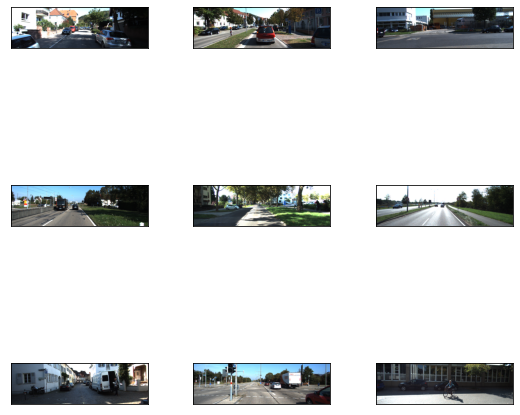

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.44778666, 0.4417955 , 0.51266664, 0.46658614]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.46, 1.66, 4.16]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-2.92,  2.1 , 46.16]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.58], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}
------filename------
007127.png


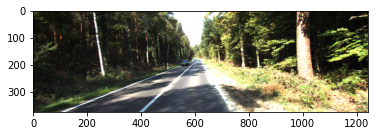

In [7]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

print('------filename------')
print(filename)


img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

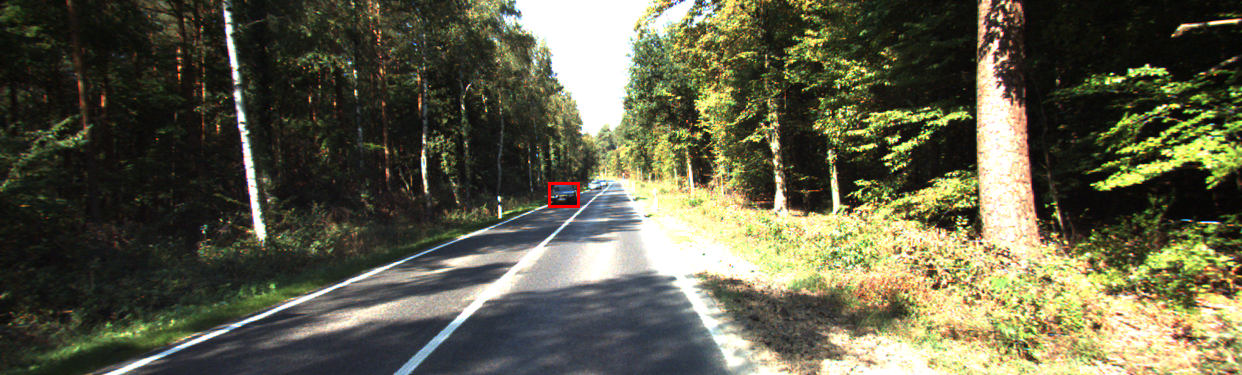

In [8]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    width, height = input_image.size

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)

    # 바운딩 박스 그리기
    for rect in rects:
        draw.rectangle(rect, outline=(255,0,0), width=3)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

#### RetinaNet 모델 설계

In [9]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [10]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [11]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [12]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [13]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [14]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [15]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [16]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [17]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [18]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [19]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [20]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [21]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

#### RetinaNet 학습

In [22]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


In [23]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [23]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset, test_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation", "test"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)




In [26]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/train_history/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}_0310"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/10
3173/3173 [==============================] - 1599s 503ms/step - loss: 1.9044 - val_loss: 1.5209

Epoch 00001: saving model to /aiffel/aiffel/object_detection/train_history/weights_epoch_1_0310
Epoch 2/10
3173/3173 [==============================] - 1602s 501ms/step - loss: 0.9572 - val_loss: 1.2063

Epoch 00002: saving model to /aiffel/aiffel/object_detection/train_history/weights_epoch_2_0310
Epoch 3/10
3173/3173 [==============================] - 1604s 501ms/step - loss: 0.7007 - val_loss: 1.0915

Epoch 00003: saving model to /aiffel/aiffel/object_detection/train_history/weights_epoch_3_0310
Epoch 4/10
3173/3173 [==============================] - 1602s 501ms/step - loss: 0.5577 - val_loss: 1.0219

Epoch 00004: saving model to /aiffel/aiffel/object_detection/train_history/weights_epoch_4_0310
Epoch 5/10
3173/3173 [==============================] - 1605s 501ms/step - loss: 0.4668 - val_loss: 0.9878

Epoch 00005: saving model to /aiffel/aiffel/object_detection/train_history/w

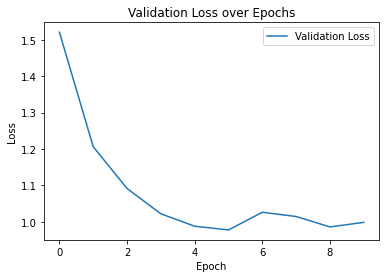

In [34]:
# history에서 val_loss 값 가져오기
val_loss = history.history['val_loss']

# val_loss 그래프 시각화
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [35]:
# val_loss가 가장 작은 지점 찾기
best_epoch = val_loss.index(min(val_loss))
print(f"Best Epoch: {best_epoch}, Best Validation Loss: {min(val_loss)}")

Best Epoch: 5, Best Validation Loss: 0.9776327610015869


In [24]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [25]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/train_history/'
best_weights_path = os.path.join(model_dir, f"weights_epoch_{5+1}_0310")  # best_epoch+1은 1-based epoch 번호
model.load_weights(best_weights_path)

In [26]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

#### object detection 결과의 시각화

In [27]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [28]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

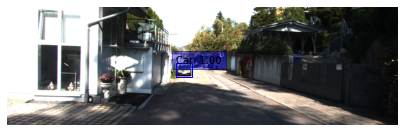

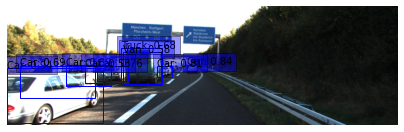

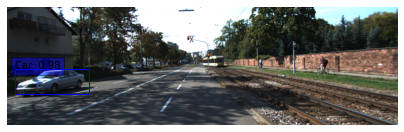

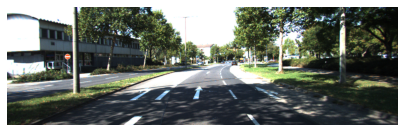

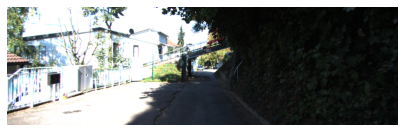

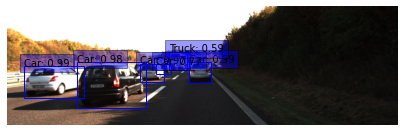

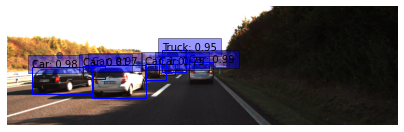

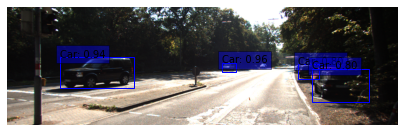

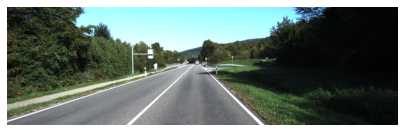

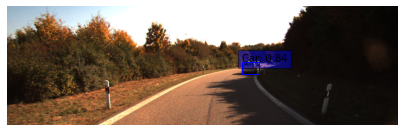

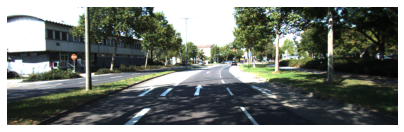

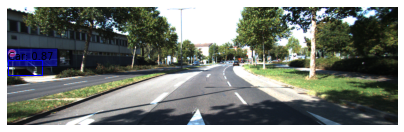

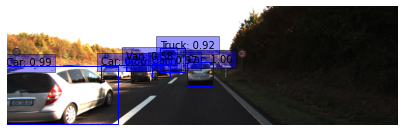

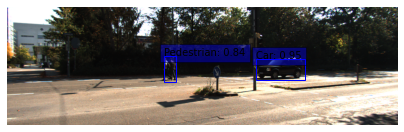

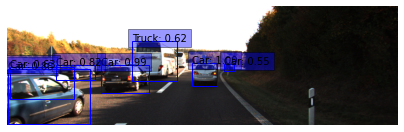

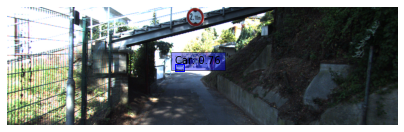

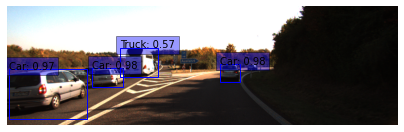

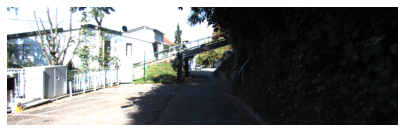

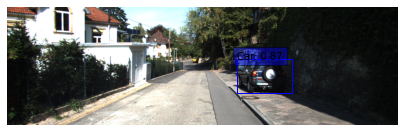

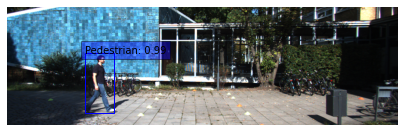

In [60]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(20):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

#### 자율주행 시스템 적용 결과

In [30]:
import os
import numpy as np
import tensorflow as tf

def self_drive_assist(img_path, size_limit=300):
    # 이미지 로드 및 전처리
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    input_image, ratio = prepare_image(image)  # 모델 입력 형태로 변환

    # 객체 탐지 수행
    detections = inference_model.predict(input_image)

    # 탐지된 객체 개수
    num_detections = int(detections.valid_detections[0])

    # 탐지된 클래스 및 박스 정보
    detected_classes = detections.nmsed_classes[0][:num_detections]
    detected_boxes = detections.nmsed_boxes[0][:num_detections] / ratio

    # 사람이 있는지 확인
    person_detected = any(int2str(int(cls)) == "Pedestrian" for cls in detected_classes)

    # 차량 크기 확인
    vehicle_detected = False
    for box in detected_boxes:
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        if width >= size_limit or height >= size_limit:
            vehicle_detected = True
            break

    # 정지 조건 확인
    if person_detected or vehicle_detected:
        return "Stop"
    
    return "Go"

# 테스트
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_1.png'
print(self_drive_assist(img_path))


Stop


In [31]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


#### 추가 실험 : 시스템 보조 로직 추가, mAP를 활용한 성능평가

In [32]:
def self_drive_assist_relative(class_names, boxes, image_width, size_limit=300, stop_threshold=150, threshold_distance=100):
    road_center_x = image_width // 2  # 도로 중앙 (예: 이미지의 절반 위치)
    
    for cls, box in zip(class_names, boxes):
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        object_center_x = (x1 + x2) / 2  # 객체의 중심 x 좌표
        
        # 🚶‍♂️ 사람이 도로 중심에 가까이 있고, 일정 크기 이상이면 Stop
        if cls in human_classes and height >= stop_threshold and abs(object_center_x - road_center_x) < threshold_distance:
            return "Stop"

        # 🚗 차량이 크고 도로 중심과 가깝다면 Stop
        if cls in vehicle_classes and (width >= size_limit or height >= size_limit) and abs(object_center_x - road_center_x) < threshold_distance:
            return "Stop"

    return "Go"

In [33]:
# 차량 및 사람 클래스 정의
vehicle_classes = ["Car", "Truck", "Van"]
human_classes = ["Pedestrian", "Sitting Human", "Cyclist"]

# 객체의 상대적 위치를 고려한 Stop/Go 판단
def label_objects(class_names, boxes, image_width, size_limit=300, pedestrian_limit=150, threshold_distance=100):
    labels = []
    road_center_x = image_width // 2  # 도로 중앙을 이미지의 절반으로 가정

    for cls, box in zip(class_names, boxes):
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        object_center_x = (x1 + x2) / 2  # 객체 중심 좌표 계산

        # 🚶‍♂️ 사람이 도로 중앙에 가까우면 Stop
        if cls in human_classes and (width >= pedestrian_limit or height >= pedestrian_limit):
            if abs(object_center_x - road_center_x) < threshold_distance:  # 도로 중앙과 가까우면 Stop
                labels.append("Stop")
                continue
        
        # 🚗 차량이 크고 도로 중앙과 가깝다면 Stop
        if cls in vehicle_classes and (width >= size_limit or height >= size_limit):
            if abs(object_center_x - road_center_x) < threshold_distance:
                labels.append("Stop")
                continue

        # 기본적으로 Go 처리
        labels.append("Go")

    return labels


보조 로직을 추가하고 레이블 수준에서 정확도를 평가하고자 하였으나 예측된 객체의 수와 정답 객체의 수가 달라 추가 조치가 필요한 상황

In [38]:
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

# 레이블 수준에서의 성능 확인
# 실제 라벨과 예측 라벨을 저장할 리스트
true_labels = []
predicted_labels = []

# 테스트 데이터셋에서 100개 샘플만 사용
for idx, sample in enumerate(test_dataset.take(100)):
    image = tf.cast(sample["image"], dtype=tf.float32)
    image_width = image.shape[1]  # 📌 이미지 너비 가져오기
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    # 📌 예측된 객체 정보 가져오기
    predicted_class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    predicted_boxes = detections.nmsed_boxes[0][:num_detections] / ratio

    # 📌 실제 라벨 정보 가져오기 (KITTI 데이터셋에서 ground truth 사용)
    true_class_names = [
        int2str(int(x)) for x in sample["objects"]["type"]
    ]
    true_boxes = np.array(sample["objects"]["bbox"]) * image.shape[0]  # 정규화된 bbox를 원래 크기로 변환

    # 객체별 라벨 결정
    predicted_labels_for_sample = label_objects(predicted_class_names, predicted_boxes, image_width=image_width)
    true_labels_for_sample = label_objects(true_class_names, true_boxes, image_width=image_width)

    # **디버깅: 예측된 객체 수와 실제 객체 수 확인**
    if len(true_labels_for_sample) != len(predicted_labels_for_sample):
        print(f"\n⚠ [샘플 {idx}] 예측된 객체 수({len(predicted_labels_for_sample)}) vs 실제 객체 수({len(true_labels_for_sample)}) 불일치!")

    # 예측되지 않은 실제 객체 추가 (Recall 반영)
    if len(true_labels_for_sample) > len(predicted_labels_for_sample):
        missing_count = len(true_labels_for_sample) - len(predicted_labels_for_sample)
        predicted_labels_for_sample.extend(["Missing"] * missing_count)  # 예측되지 않은 객체를 "Missing"으로 추가

    # 실제보다 예측이 많으면 그대로 사용 (False Positive 반영)
    
    true_labels.extend(true_labels_for_sample)
    predicted_labels.extend(predicted_labels_for_sample)
    
print(len(true_labels))  # Check the number of true labels
print(len(predicted_labels))  # Check the number of predicted labels

# **객체별 성능 평가**
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels))



⚠ [샘플 1] 예측된 객체 수(9) vs 실제 객체 수(8) 불일치!

⚠ [샘플 2] 예측된 객체 수(1) vs 실제 객체 수(3) 불일치!

⚠ [샘플 3] 예측된 객체 수(0) vs 실제 객체 수(1) 불일치!

⚠ [샘플 4] 예측된 객체 수(0) vs 실제 객체 수(1) 불일치!

⚠ [샘플 5] 예측된 객체 수(6) vs 실제 객체 수(9) 불일치!

⚠ [샘플 6] 예측된 객체 수(7) vs 실제 객체 수(11) 불일치!

⚠ [샘플 7] 예측된 객체 수(4) vs 실제 객체 수(5) 불일치!

⚠ [샘플 8] 예측된 객체 수(0) vs 실제 객체 수(1) 불일치!

⚠ [샘플 9] 예측된 객체 수(1) vs 실제 객체 수(3) 불일치!

⚠ [샘플 10] 예측된 객체 수(0) vs 실제 객체 수(1) 불일치!

⚠ [샘플 11] 예측된 객체 수(1) vs 실제 객체 수(2) 불일치!

⚠ [샘플 12] 예측된 객체 수(7) vs 실제 객체 수(12) 불일치!

⚠ [샘플 13] 예측된 객체 수(2) vs 실제 객체 수(3) 불일치!

⚠ [샘플 14] 예측된 객체 수(7) vs 실제 객체 수(9) 불일치!

⚠ [샘플 16] 예측된 객체 수(4) vs 실제 객체 수(8) 불일치!

⚠ [샘플 17] 예측된 객체 수(0) vs 실제 객체 수(1) 불일치!

⚠ [샘플 21] 예측된 객체 수(2) vs 실제 객체 수(3) 불일치!

⚠ [샘플 22] 예측된 객체 수(7) vs 실제 객체 수(12) 불일치!

⚠ [샘플 23] 예측된 객체 수(7) vs 실제 객체 수(10) 불일치!

⚠ [샘플 25] 예측된 객체 수(8) vs 실제 객체 수(6) 불일치!

⚠ [샘플 26] 예측된 객체 수(5) vs 실제 객체 수(8) 불일치!

⚠ [샘플 28] 예측된 객체 수(3) vs 실제 객체 수(7) 불일치!

⚠ [샘플 30] 예측된 객체 수(4) vs 실제 객체 수(10) 불일치!

⚠ [샘플 31] 예측된 객체 수(1) vs 실제 객체 수(3) 불

ValueError: Found input variables with inconsistent numbers of samples: [519, 530]

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# 시각화 함수
def visualize_bboxes(image, true_boxes, predicted_boxes, true_labels, predicted_labels, ratio):
    # 이미지를 uint8 타입으로 변환
    image = np.array(image, dtype=np.uint8)

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)  # 이미지 표시

    # 실제 bbox (Ground Truth)
    for i, true_box in enumerate(true_boxes):
        x1, y1, x2, y2 = true_box
        
        # 이미지 크기에 맞게 좌표 정규화
        origin_x, origin_y = x1, image.shape[0] - y2  # Y축을 반전시켜야 matplotlib의 좌하단 원점에 맞게 설정
        w, h = x2 - x1, y2 - y1

        rect = patches.Rectangle(
            (origin_x, origin_y), w, h,
            linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth'
        )
        ax.add_patch(rect)
        ax.text(
            origin_x, origin_y, true_labels[i],
            color="green", fontsize=10, verticalalignment="bottom", horizontalalignment="left",
            bbox={'facecolor': 'green', 'alpha': 0.3, 'pad': 0.5}
        )

    # 예측 bbox (Predicted)
    for i, pred_box in enumerate(predicted_boxes):
        x1, y1, x2, y2 = pred_box
        
        # 이미지 크기에 맞게 좌표 정규화
        origin_x, origin_y = x1, image.shape[0] - y2  # Y축을 반전시켜야 matplotlib의 좌하단 원점에 맞게 설정
        w, h = x2 - x1, y2 - y1
        
        rect = patches.Rectangle(
            (origin_x, origin_y), w, h,
            linewidth=2, edgecolor='red', facecolor='none', label='Prediction'
        )
        ax.add_patch(rect)
        ax.text(
            origin_x, origin_y, predicted_labels[i],
            color="red", fontsize=10, verticalalignment="bottom", horizontalalignment="left",
            bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 0.5}
        )

    plt.axis('off')
    plt.show()


ground truth의 bbox를 정규화하는 방법에서 문제 발생

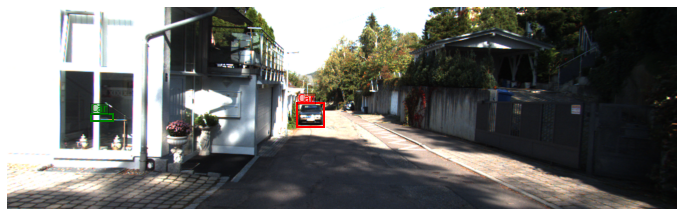

true_boxes: [[154.06999 162.59058 195.88    176.73611]]
predicted_boxes: [[537.2548  153.09546 586.7709  195.87129]]
true_labels: ['Car']
predicted_labels: ['Car']
True Positives (TP): 0
False Positives (FP): 1
False Negatives (FN): 1
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/conda/lib/python3.9/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [74]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.patches as patches  # 이 줄을 추가

# IoU 계산 함수 (두 박스의 Intersection over Union 계산)
def compute_iou(box1, box2):
    # box는 [ymin, xmin, ymax, xmax] 형식
    y_min = max(box1[0], box2[0])
    x_min = max(box1[1], box2[1])
    y_max = min(box1[2], box2[2])
    x_max = min(box1[3], box2[3])

    intersection_area = max(0, y_max - y_min) * max(0, x_max - x_min)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = area_box1 + area_box2 - intersection_area

    return intersection_area / union_area if union_area > 0 else 0

# 예측된 박스와 실제 박스를 비교하여 TP, FP, FN 계산
def evaluate_detection(true_boxes, predicted_boxes, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    # 예측된 박스와 실제 박스를 비교
    matched = []
    for true_box in true_boxes:
        matched_for_true = False
        for pred_idx, pred_box in enumerate(predicted_boxes):
            if pred_idx not in matched:
                iou = compute_iou(true_box, pred_box)
                if iou >= iou_threshold:
                    tp += 1
                    matched_for_true = True
                    matched.append(pred_idx)
                    break
        if not matched_for_true:
            fn += 1

    # 남은 예측은 FP로 간주
    fp += len(predicted_boxes) - len(matched)

    return tp, fp, fn

# 성능 평가 (단일 이미지에 대해)
def evaluate_single_image(true_boxes, predicted_boxes, true_labels, predicted_labels, iou_threshold=0.5):
    tp, fp, fn = evaluate_detection(true_boxes, predicted_boxes, iou_threshold)
    
    # Precision, Recall, F1 Score 계산
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='binary', zero_division=0
    )
    
    return tp, fp, fn, precision, recall, f1_score

# 예측 및 평가 코드
sample = next(iter(test_dataset.take(1)))  # 'iter'로 변환하여 첫 번째 샘플을 가져오기
image = tf.cast(sample["image"], dtype=tf.float32)
image_width = image.shape[1]
input_image, ratio = prepare_image(image)
detections = inference_model.predict(input_image)
num_detections = detections.valid_detections[0]

# 예측된 객체 정보
predicted_class_names = [
    int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
]
predicted_boxes = detections.nmsed_boxes[0][:num_detections] / ratio

# 실제 라벨 정보 (KITTI 데이터셋에서 ground truth 사용)
true_class_names = [
    int2str(int(x)) for x in sample["objects"]["type"]
]
true_boxes = np.array(sample["objects"]["bbox"]) * image.shape[0]  # 정규화된 bbox를 원래 크기로 변환

# 예측된 클래스와 실제 클래스의 일치를 비교
true_labels = true_class_names
predicted_labels = predicted_class_names

# 시각화
visualize_bboxes(image, true_boxes, predicted_boxes, true_labels, predicted_labels, ratio)

# 성능 평가
tp, fp, fn, precision, recall, f1_score = evaluate_single_image(
    true_boxes, predicted_boxes, true_labels, predicted_labels, iou_threshold=0.5
)

# 결과 출력
print(f"true_boxes: {true_boxes}")
print(f"predicted_boxes: {predicted_boxes}")

print(f"true_labels: {true_labels}")
print(f"predicted_labels: {predicted_labels}")


print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


#### 회고

Object detection을 평가하는 부분에서 처음에는 레이블 수준에서 평가하면 되겠다는 생각에 예측한 레이블과 정답 레이블을 비교하고 일치하면 TP로 평가하는 단순 합계로 코드를 작성한 다음 다시 회고해보니 중복 레이블에 대해 적절히 계산하지 못했던 부분을 발견하여 이를 수정하고자 노력하였으나, 어려움을 겪고 뒤늦게 IOU방식의 평가방법을 사용하여 mAP로 평가하려고 하였으나 정규화하는 부분에서 문제가 발생하여 추후에 이를 수정하여 프로젝트를 마무리하겠습니다..